### WETSNOW


In [1]:
# %matplotlib widget
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

import pyproj
from pystac_client import Client
from odc.stac import stac_load
import wget
import xarray as xr

In [2]:
collection = "SENTINEL1_ALPS_WETSNOW"

bbox = [6, 47, 7, 48]

In [3]:
client = Client.open('https://stac.eodc.eu/api/v1')
results = client.search(collections=collection,
    max_items=10,
    bbox=bbox,
)
result_items = list(results.items())
result_items

[<Item id=WSM_ALPS_20210730T172347_E048N012T6_S1A_IW_SLC_039010_004562_00_ENVEO>,
 <Item id=WSM_ALPS_20210730T172347_E042N018T6_S1A_IW_SLC_039010_004562_00_ENVEO>,
 <Item id=WSM_ALPS_20210730T172347_E042N012T6_S1A_IW_SLC_039010_004562_00_ENVEO>,
 <Item id=WSM_ALPS_20210730T172347_E042N006T6_S1A_IW_SLC_039010_004562_00_ENVEO>,
 <Item id=WSM_ALPS_20210730T163418_E048N012T6_S1B_IW_SLC_028026_00436A_00_ENVEO>,
 <Item id=WSM_ALPS_20210729T173114_E042N018T6_S1B_IW_SLC_028012_00431A_00_ENVEO>,
 <Item id=WSM_ALPS_20210729T173114_E042N012T6_S1B_IW_SLC_028012_00431A_00_ENVEO>,
 <Item id=WSM_ALPS_20210729T173114_E042N006T6_S1B_IW_SLC_028012_00431A_00_ENVEO>,
 <Item id=WSM_ALPS_20210728T054318_E042N018T6_S1B_IW_SLC_027990_004296_00_ENVEO>,
 <Item id=WSM_ALPS_20210728T054318_E042N012T6_S1B_IW_SLC_027990_004296_00_ENVEO>]

In [4]:
result_items[0]

<Item id=WSM_ALPS_20210730T172347_E048N012T6_S1A_IW_SLC_039010_004562_00_ENVEO>

In [5]:
crs = pyproj.CRS.from_wkt("PROJCS[\"Azimuthal_Equidistant\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0],UNIT[\"degree\",0.0174532925199433],AUTHORITY[\"EPSG\",\"4326\"]],PROJECTION[\"Azimuthal_Equidistant\"],PARAMETER[\"false_easting\",4340913.84808],PARAMETER[\"false_northing\",4812712.92347],PARAMETER[\"longitude_of_center\",94.0],PARAMETER[\"latitude_of_center\",47.0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]]]")
resolution = 200
# crs = pyproj.CRS("epsg:4326")
# resolution = 0.0009

data = stac_load(
    result_items, 
    chunks={"x": 1000, "y": 1000}, 
    bands=["WSM"],
    crs=crs,
    resolution=resolution,
    )

wsm = data.WSM

wsm

<xarray.DataArray 'WSM' (time: 4, y: 99461, x: 83586)> Size: 133GB
dask.array<WSM, shape=(4, 99461, 83586), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 796kB 9.496e+06 9.495e+06 ... -1.04e+07 -1.04e+07
  * x            (x) float64 669kB -1.309e+06 -1.308e+06 ... 1.541e+07 1.541e+07
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 32B 2021-07-28T05:43:18 ... 2021-07-30...

In [6]:
unique, counts = np.unique(wsm[0, 4450:6800, 0:4000], return_counts=True)

unique

/home/vhutter/testing/.venv/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/vhutter/testing/.venv/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


array([110., 125., 200., 210., 220.,  nan], dtype=float32)

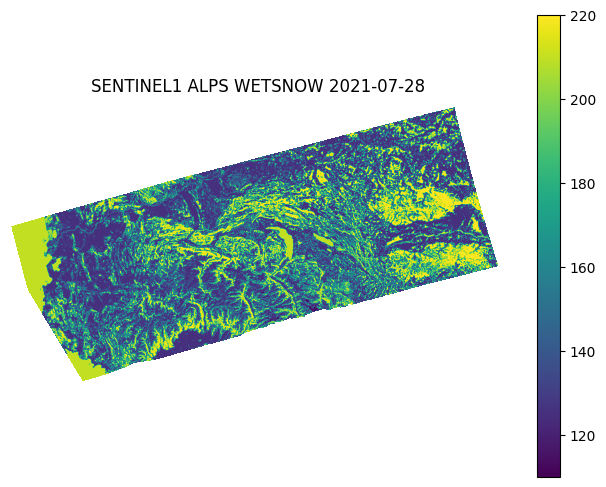

In [7]:
collection_name = collection.replace("_", " ")
t = 0

plt.figure(figsize=(8,6))
plt.imshow(wsm[t, 4450:6800, 0:4000])
time = np.datetime64(wsm['time'].values[t], "D")
plt.title(f"{collection_name} {time}")
plt.axis("off")
plt.colorbar()
plt.show()